<font size="10">Forecasting the Henon Map with Neural Networks</font>

<font size="4">This notebook employs a feedforward neural network architecture to forecast orbits of the [Henon map](https://en.wikipedia.org/wiki/H%C3%A9non_map) at chaotic parameter values. The loss function includes a parameter "steps" that allows one to incorprorate the sequential property of the data into the network training. That is, the loss function includes knowledge of not just stepping from one iterate to the next, but compositions of the network with itself to move a point further into the future.</font>

<font size="4">This code was written by Mohit Sahu and accompanies the work in Section 5.3 of the book. <i>Data-Driven Methods for Dynamic Systems</i>. This script was adapted from the Tensorflow version by Jason J. Bramburger. We use PyTorch 2.3.0 to build the neural network</font>

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [80]:
# Henon Map
def Henon(x,a = 1.4, b = 0.3):

    xnp1 = [1 - a*x[0]**2 + x[1], b*x[0]]

    return xnp1

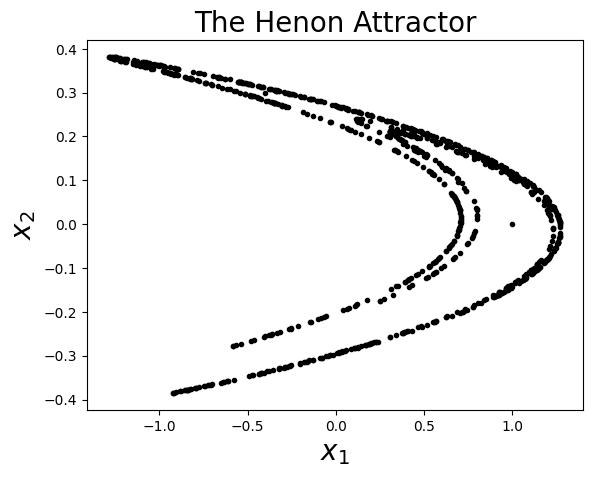

In [81]:
# Generate Henon Data

# Henon parameters
a = 1.4
b = 0.3 # Text uses b = 0.01 or b = 0.3

# Initializations
N = 1001
x = np.zeros((N,2))
x[0] = [1, 0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for n in range(1,N):
    x[n] = Henon(x[n-1], a, b)

# Plot Henon Trajectories
fig = plt.figure()
plt.plot(x[:,0],x[:,1],'k.')
plt.title('The Henon Attractor', fontsize = 20)
plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)

# Build input data matrix of forward iterates
forward_iters = 10
xnforward = []

for j in range(forward_iters):
    xnforward.append(torch.tensor(x[j:-forward_iters+j], dtype=torch.float32).to(device))

In [82]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers=4, num_neurons_per_layer=20):
        super(NeuralNetwork, self).__init__()

        # Input is two-dimensional - each component of the Henon output
        self.input_layer = nn.Linear(2, num_neurons_per_layer)

        # Activation function
        self.relu = nn.ReLU()

        # Append hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer,num_neurons_per_layer)

            for _ in range(num_hidden_layers)
        ])

        # Output is 2D - next step of Henon map
        self.output_layer = nn.Linear(num_neurons_per_layer, 2)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        # Forward pass through layers
        x = self.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

In [83]:
def compute_loss(model, xnforward, steps):
    loss = 0

    for s in range(steps):
        if s == 0:
            xpred = model(xnforward[0])
        else:
            xpred = model(xpred)

        xnp1 = xnforward[s+1]

        loss += torch.mean( torch.square( xpred - xnp1 ) )/steps

    return loss

In [8]:
# Initialize model aka tilde u
model = NeuralNetwork().to(device)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

# Learning rate schedule
lr_schedule = [1e-2, 1e-3, 1e-4]
def get_lr(epoch):
    if epoch < 1000:
        return lr_schedule[0]
    elif epoch < 3000:
        return lr_schedule[1]
    else:
        return lr_schedule[2]

# Choose the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr_schedule[0])

steps = 4

# Number of training epochs
N = 10000
hist = []

In [9]:
# Start timer
t0 = time()

for i in range(N+1):
    # Update learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = get_lr(i)

    # Reset gradient of optimizer to 0
    optimizer.zero_grad()

    # Compute loss
    loss = compute_loss(model, xnforward, steps)
    loss.backward()

    # Perform gradient descent step
    optimizer.step()

    # Append current loss to hist
    hist.append(loss.item())

    # Output current loss after 50 iterates
    if i % 50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss.item()))

        # Implementing early stopping
        if loss.item() < 1e-5:
            break

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 3.24424416e-01
It 00050: loss = 4.23768647e-02
It 00100: loss = 4.97987531e-02
It 00150: loss = 1.12001970e-02
It 00200: loss = 9.00095142e-03
It 00250: loss = 4.41010110e-03
It 00300: loss = 7.26892846e-03
It 00350: loss = 4.62163053e-03
It 00400: loss = 2.19644653e-03
It 00450: loss = 5.60632092e-04
It 00500: loss = 1.46047748e-03
It 00550: loss = 4.09897324e-03
It 00600: loss = 1.70606514e-03
It 00650: loss = 2.15704786e-03
It 00700: loss = 6.99742581e-04
It 00750: loss = 2.76951841e-03
It 00800: loss = 1.46982842e-03
It 00850: loss = 1.96046149e-03
It 00900: loss = 4.15092148e-03
It 00950: loss = 3.97125212e-03
It 01000: loss = 2.01987522e-03
It 01050: loss = 2.48740573e-04
It 01100: loss = 2.19654874e-04
It 01150: loss = 2.03909498e-04
It 01200: loss = 1.92577689e-04
It 01250: loss = 1.84353587e-04
It 01300: loss = 1.77463575e-04
It 01350: loss = 1.71386622e-04
It 01400: loss = 1.66475133e-04
It 01450: loss = 1.62574637e-04
It 01500: loss = 1.59499323e-04
It 01550

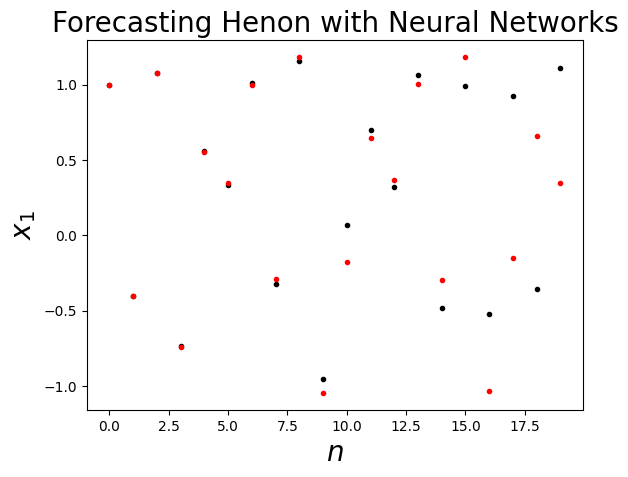

In [13]:
# Use Trained Model to Forecast
M = 101

xpred = torch.zeros((M,2)).to(device)
xpred[0] = torch.tensor(x[0,:], dtype=torch.float32).to(device)

for m in range(1,M):
    xpred[m] = model(xpred[m-1:m,:])

# Plot Henon Trajectories
fig = plt.figure()
plt.plot(xpred[:20,0].cpu().detach(),'k.')
plt.plot(x[:20,0],'r.')
plt.title('Forecasting Henon with Neural Networks', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20);

In [95]:
# Load and view saved models
import tf2onnx
import tensorflow as tf
from onnx2pytorch import ConvertModel

def loadModel(file_path):
    """To Load Tensorflow model"""
    loaded_model = tf.keras.models.load_model(file_path, compile=False)
    onnx_model, _ = tf2onnx.convert.from_keras(loaded_model)
    pytorch_model = ConvertModel(onnx_model)

    return pytorch_model

pytorch_model = loadModel('../Henon_models/Henon_step=3_b=0_01')

# Check loss on training data
loss = compute_loss(model, xnforward, steps)
print('loss on training data = ', loss.item())

loss on training data =  3.475221456028521e-05


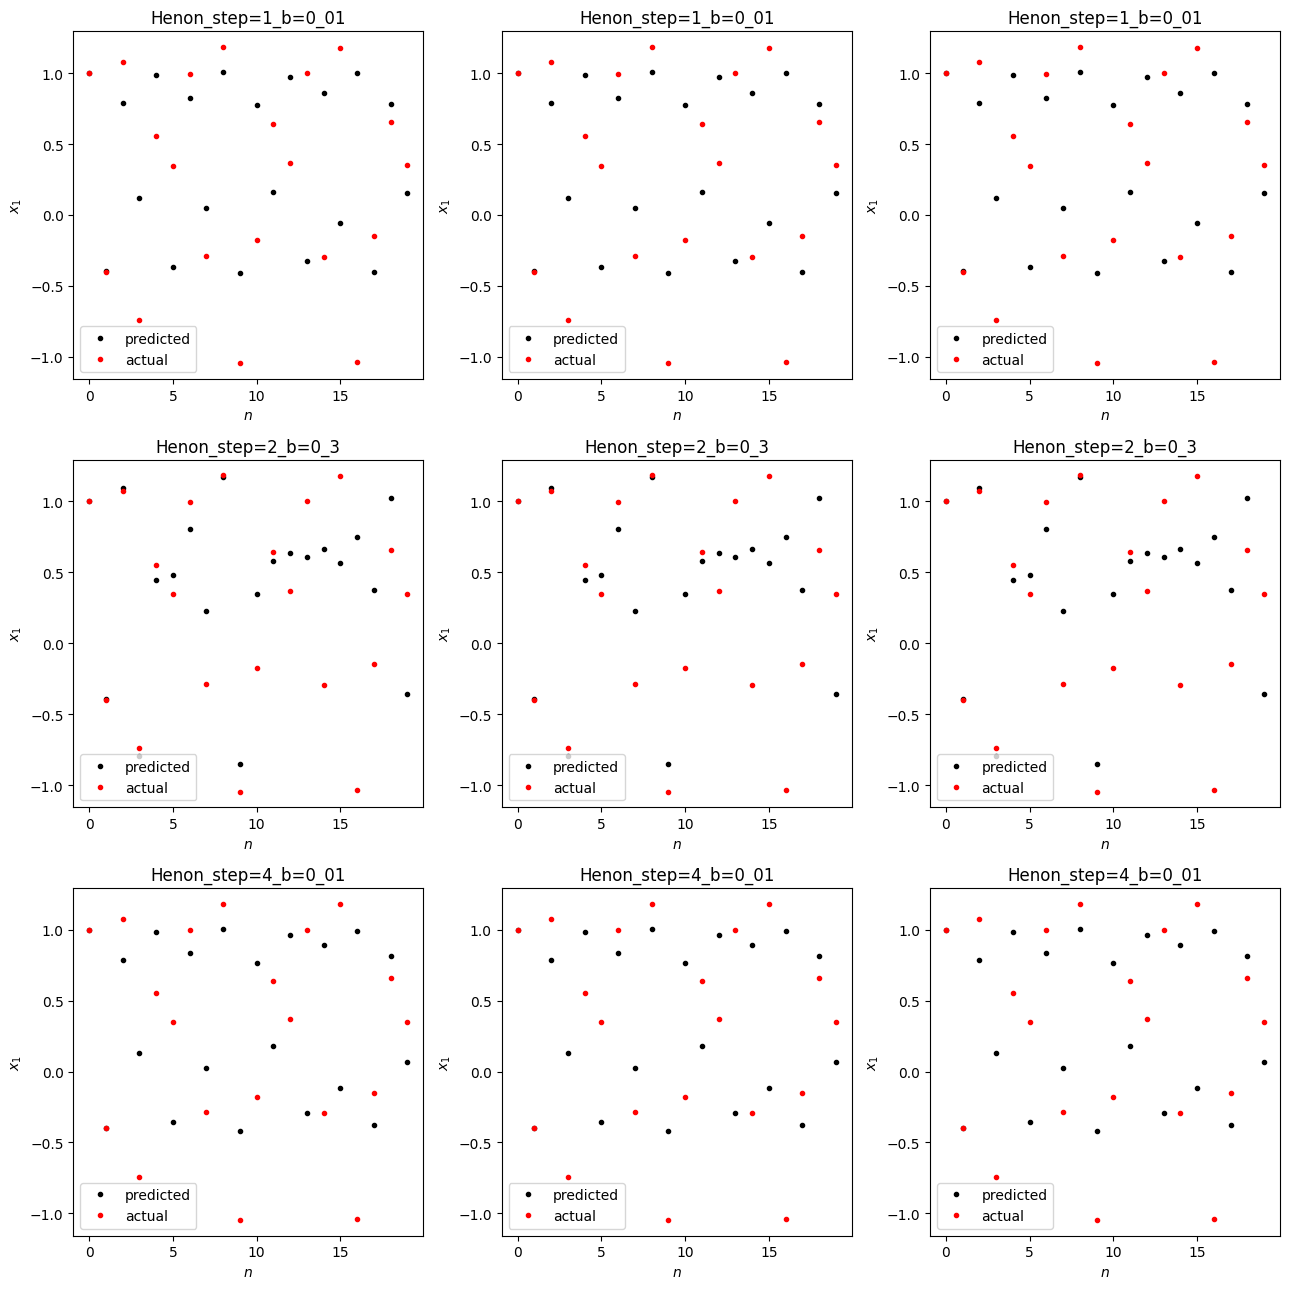

In [ ]:
import os
file_path = os.listdir("../Henon_models/")

# Seeing the forecasting of all trained models
fig, axes = plt.subplots(3, 3, figsize=(13, 13))
M = 101

# Forecast data
xpred = torch.zeros((M,2)).to(device)
xpred[0] = torch.tensor(x[0,:], dtype=torch.float32).to(device)

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
                
        pytorch_model = loadModel(f'../Henon_models/{file_path[3*i+1]}')

        for m in range(1,M):
            xpred[m] = pytorch_model(xpred[m-1:m,:])

        ax.plot(xpred[:20,0].cpu().detach(),'k.', label='predicted')
        ax.plot(x[:20,0],'r.', label='actual')
        
        # Set titles and labels
        ax.set_title(f'{file_path[3*i+1]}')
        ax.set_xlabel('$n$')
        ax.set_ylabel('$x_1$')
        
        ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()